# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        self.dp_value = 0.06
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(self.dp_value),
        ) # output_size = 26, RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(self.dp_value),
        ) # output_size = 24, RF = 5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12, RF = 6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(self.dp_value),
        ) # output_size = 12, RF = 6
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16), 
            nn.Dropout(self.dp_value),           
        ) # output_size = 10, RF = 10

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(self.dp_value),            
        ) # output_size = 8, RF = 14

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(self.dp_value),           
        ) # output_size = 6, RF = 18
      
        # OUTPUT BLOCK
        self.GAP = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)

        x = self.GAP(x)        
        x = self.convblock7(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
      BatchNorm2d-10            [-1, 8, 24, 24]              16
          Dropout-11            [-1, 8, 24, 24]               0
        MaxPool2d-12            [-1, 8, 12, 12]               0
           Conv2d-13           [-1, 16, 10, 10]           1,152
             ReLU-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [8]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.06242263317108154 Batch_id=937 Accuracy=90.85: 100%|██████████| 938/938 [00:19<00:00, 47.89it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0896, Accuracy: 9728/10000 (97.28%)

EPOCH: 1


Loss=0.13184325397014618 Batch_id=937 Accuracy=97.36: 100%|██████████| 938/938 [00:19<00:00, 48.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0490, Accuracy: 9857/10000 (98.57%)

EPOCH: 2


Loss=0.032585278153419495 Batch_id=937 Accuracy=97.89: 100%|██████████| 938/938 [00:18<00:00, 50.74it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0338, Accuracy: 9886/10000 (98.86%)

EPOCH: 3


Loss=0.006857872009277344 Batch_id=937 Accuracy=98.09: 100%|██████████| 938/938 [00:18<00:00, 50.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0331, Accuracy: 9890/10000 (98.90%)

EPOCH: 4


Loss=0.22161470353603363 Batch_id=937 Accuracy=98.32: 100%|██████████| 938/938 [00:17<00:00, 52.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9900/10000 (99.00%)

EPOCH: 5


Loss=0.030533432960510254 Batch_id=937 Accuracy=98.41: 100%|██████████| 938/938 [00:17<00:00, 52.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9915/10000 (99.15%)

EPOCH: 6


Loss=0.03216495364904404 Batch_id=937 Accuracy=98.42: 100%|██████████| 938/938 [00:18<00:00, 51.30it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9900/10000 (99.00%)

EPOCH: 7


Loss=0.02263665199279785 Batch_id=937 Accuracy=98.60: 100%|██████████| 938/938 [00:18<00:00, 51.95it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9901/10000 (99.01%)

EPOCH: 8


Loss=0.006931915879249573 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [00:18<00:00, 51.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9906/10000 (99.06%)

EPOCH: 9


Loss=0.0066886842250823975 Batch_id=937 Accuracy=98.74: 100%|██████████| 938/938 [00:18<00:00, 49.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9912/10000 (99.12%)

EPOCH: 10


Loss=0.009481742978096008 Batch_id=937 Accuracy=98.70: 100%|██████████| 938/938 [00:18<00:00, 51.43it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9901/10000 (99.01%)

EPOCH: 11


Loss=0.08390405029058456 Batch_id=937 Accuracy=98.78: 100%|██████████| 938/938 [00:18<00:00, 51.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9902/10000 (99.02%)

EPOCH: 12


Loss=0.03845059871673584 Batch_id=937 Accuracy=98.81: 100%|██████████| 938/938 [00:18<00:00, 49.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9923/10000 (99.23%)

EPOCH: 13


Loss=0.025594010949134827 Batch_id=937 Accuracy=98.85: 100%|██████████| 938/938 [00:18<00:00, 50.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9926/10000 (99.26%)

EPOCH: 14


Loss=0.004952773451805115 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [00:18<00:00, 50.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9919/10000 (99.19%)

EPOCH: 15


Loss=0.0037206560373306274 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [00:18<00:00, 49.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9933/10000 (99.33%)

EPOCH: 16


Loss=0.004031181335449219 Batch_id=937 Accuracy=98.84: 100%|██████████| 938/938 [00:18<00:00, 51.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9923/10000 (99.23%)

EPOCH: 17


Loss=0.016379430890083313 Batch_id=937 Accuracy=98.91: 100%|██████████| 938/938 [00:17<00:00, 53.38it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9935/10000 (99.35%)

EPOCH: 18


Loss=0.020792275667190552 Batch_id=937 Accuracy=98.90: 100%|██████████| 938/938 [00:17<00:00, 52.17it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9913/10000 (99.13%)

EPOCH: 19


Loss=0.012682586908340454 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [00:17<00:00, 52.89it/s]



Test set: Average loss: 0.0183, Accuracy: 9934/10000 (99.34%)



Text(0.5, 1.0, 'Test Accuracy')

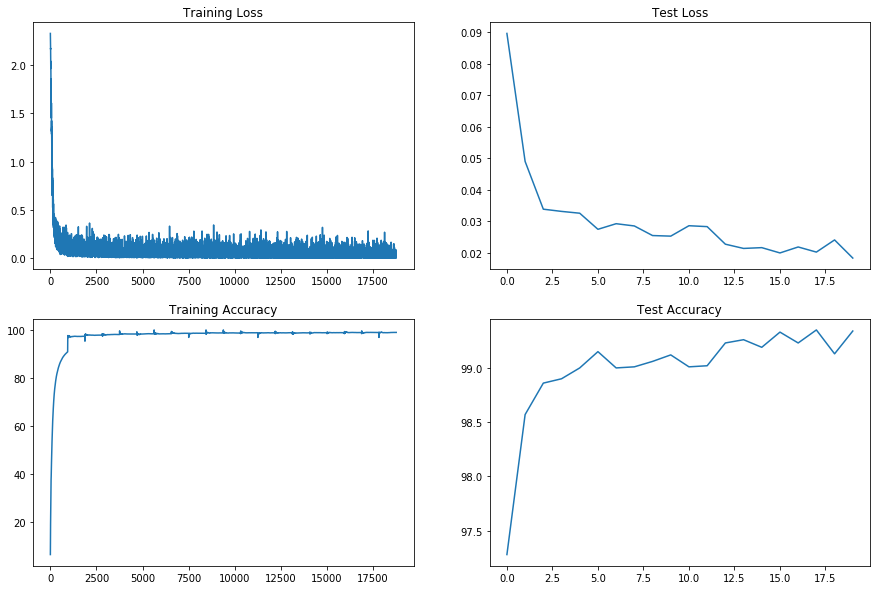

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

# Finding Misclassified Images



1 [ Predicted Value: 8, Actual Value: 6 ]


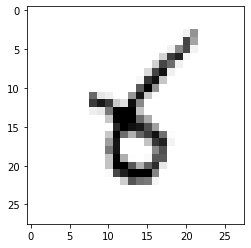



2 [ Predicted Value: 5, Actual Value: 3 ]


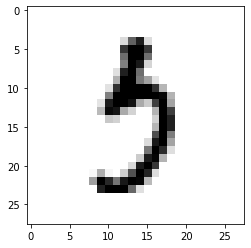



3 [ Predicted Value: 0, Actual Value: 9 ]


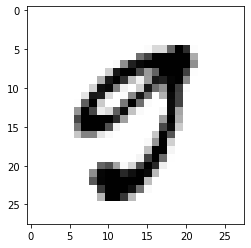



4 [ Predicted Value: 9, Actual Value: 4 ]


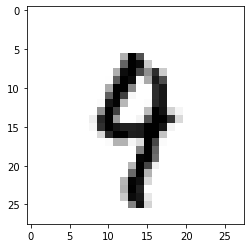



5 [ Predicted Value: 5, Actual Value: 9 ]


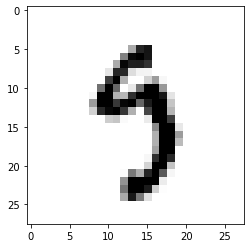



6 [ Predicted Value: 1, Actual Value: 7 ]


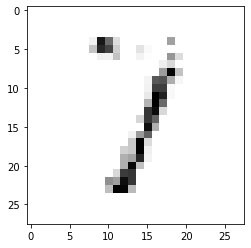



7 [ Predicted Value: 9, Actual Value: 4 ]


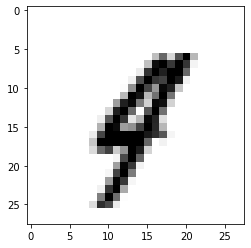



8 [ Predicted Value: 6, Actual Value: 5 ]


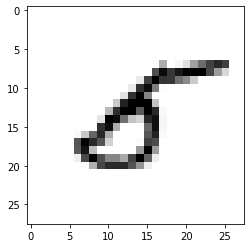



9 [ Predicted Value: 9, Actual Value: 4 ]


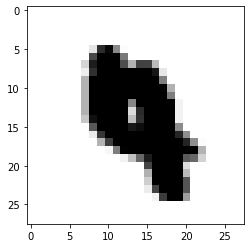



10 [ Predicted Value: 9, Actual Value: 8 ]


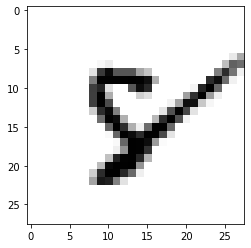



11 [ Predicted Value: 3, Actual Value: 2 ]


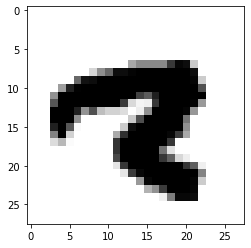



12 [ Predicted Value: 9, Actual Value: 8 ]


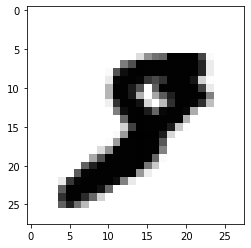



13 [ Predicted Value: 0, Actual Value: 6 ]


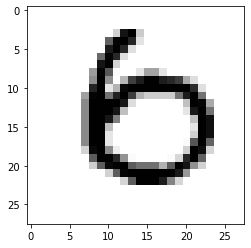



14 [ Predicted Value: 5, Actual Value: 3 ]


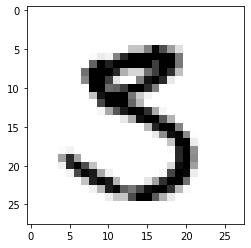



15 [ Predicted Value: 5, Actual Value: 9 ]


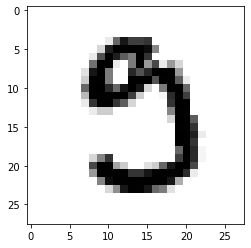



16 [ Predicted Value: 1, Actual Value: 6 ]


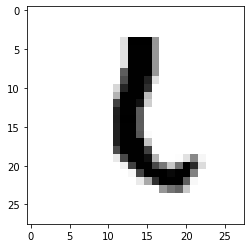



17 [ Predicted Value: 2, Actual Value: 7 ]


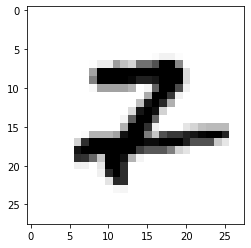



18 [ Predicted Value: 0, Actual Value: 2 ]


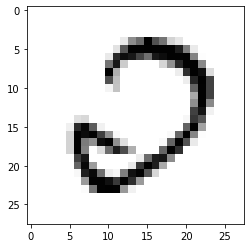



19 [ Predicted Value: 9, Actual Value: 7 ]


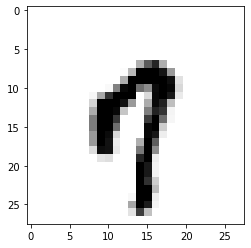



20 [ Predicted Value: 4, Actual Value: 9 ]


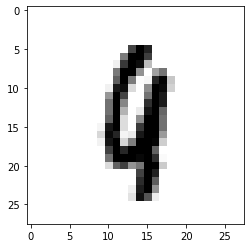



21 [ Predicted Value: 2, Actual Value: 7 ]


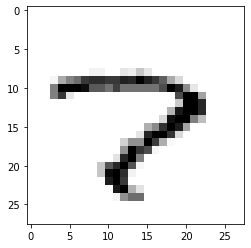



22 [ Predicted Value: 3, Actual Value: 5 ]


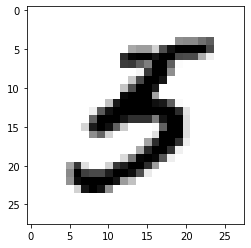



23 [ Predicted Value: 4, Actual Value: 9 ]


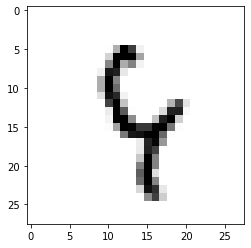



24 [ Predicted Value: 3, Actual Value: 5 ]


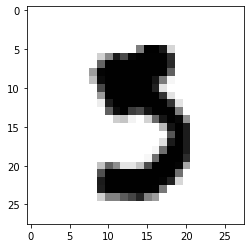



25 [ Predicted Value: 0, Actual Value: 6 ]


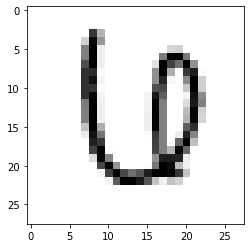



26 [ Predicted Value: 6, Actual Value: 5 ]


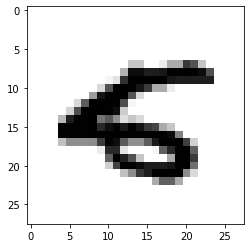



27 [ Predicted Value: 1, Actual Value: 7 ]


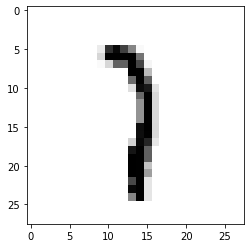



28 [ Predicted Value: 9, Actual Value: 4 ]


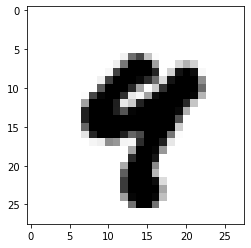



29 [ Predicted Value: 2, Actual Value: 1 ]


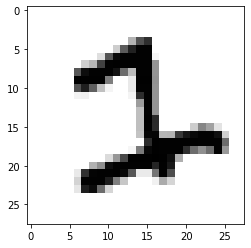



30 [ Predicted Value: 0, Actual Value: 6 ]


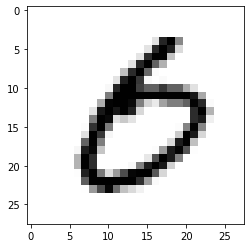



31 [ Predicted Value: 7, Actual Value: 9 ]


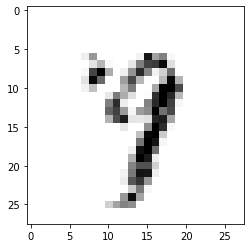



32 [ Predicted Value: 0, Actual Value: 8 ]


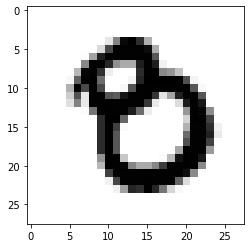



33 [ Predicted Value: 5, Actual Value: 3 ]


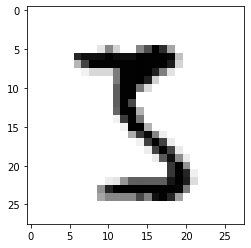



34 [ Predicted Value: 9, Actual Value: 4 ]


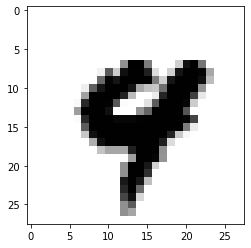



35 [ Predicted Value: 0, Actual Value: 5 ]


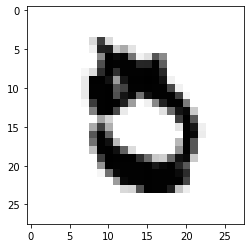



36 [ Predicted Value: 9, Actual Value: 3 ]


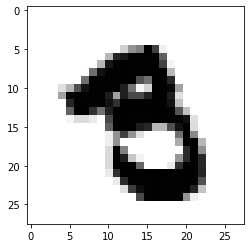



37 [ Predicted Value: 9, Actual Value: 8 ]


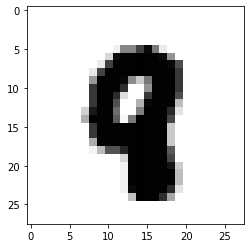



38 [ Predicted Value: 2, Actual Value: 7 ]


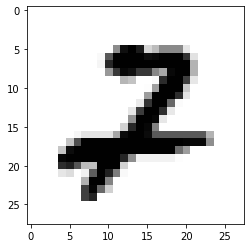



39 [ Predicted Value: 5, Actual Value: 9 ]


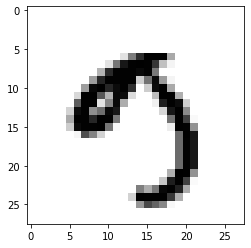



40 [ Predicted Value: 0, Actual Value: 9 ]


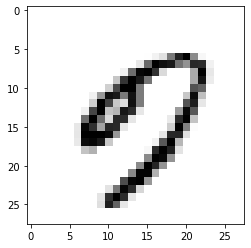



41 [ Predicted Value: 5, Actual Value: 6 ]


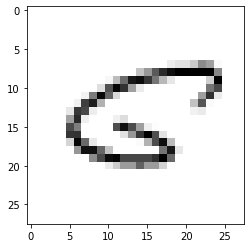



42 [ Predicted Value: 9, Actual Value: 4 ]


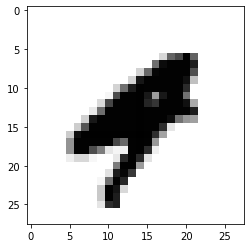



43 [ Predicted Value: 8, Actual Value: 6 ]


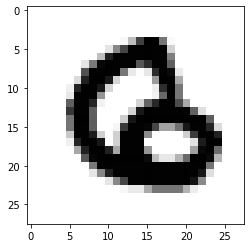



44 [ Predicted Value: 6, Actual Value: 0 ]


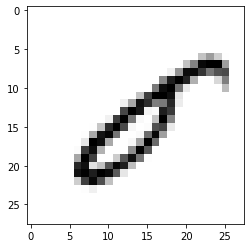



45 [ Predicted Value: 7, Actual Value: 2 ]


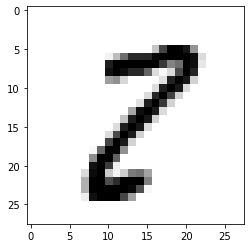



46 [ Predicted Value: 1, Actual Value: 2 ]


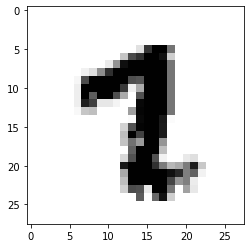



47 [ Predicted Value: 6, Actual Value: 0 ]


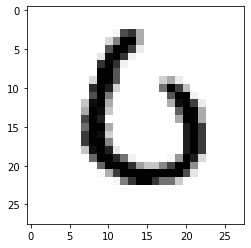



48 [ Predicted Value: 2, Actual Value: 8 ]


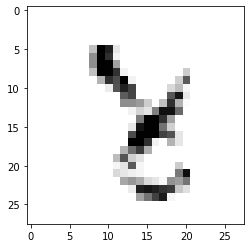



49 [ Predicted Value: 5, Actual Value: 9 ]


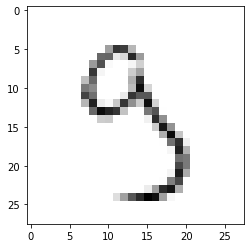



50 [ Predicted Value: 1, Actual Value: 7 ]


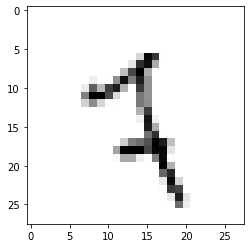



51 [ Predicted Value: 5, Actual Value: 3 ]


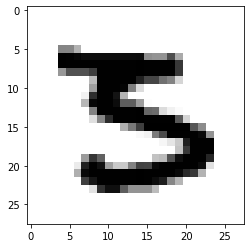



52 [ Predicted Value: 2, Actual Value: 3 ]


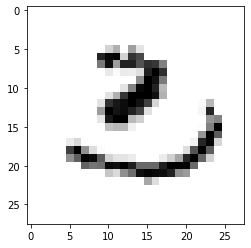



53 [ Predicted Value: 3, Actual Value: 5 ]


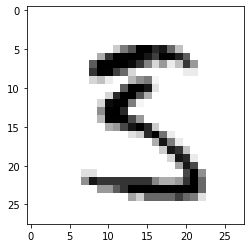



54 [ Predicted Value: 1, Actual Value: 6 ]


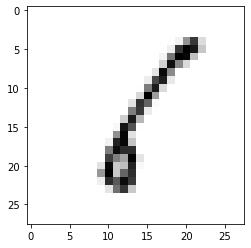



55 [ Predicted Value: 2, Actual Value: 7 ]


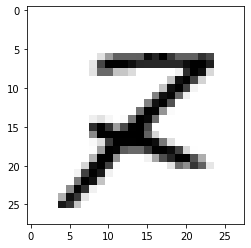



56 [ Predicted Value: 9, Actual Value: 4 ]


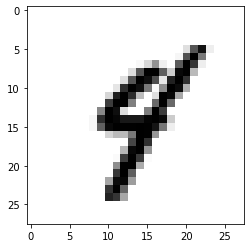



57 [ Predicted Value: 0, Actual Value: 2 ]


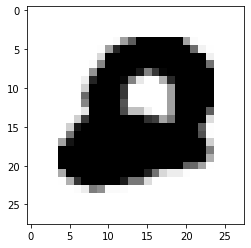



58 [ Predicted Value: 0, Actual Value: 6 ]


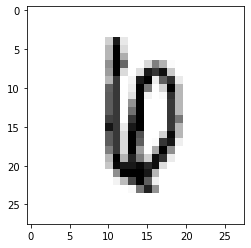



59 [ Predicted Value: 6, Actual Value: 5 ]


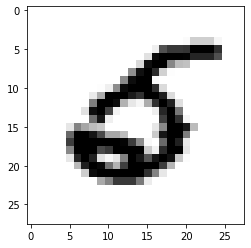



60 [ Predicted Value: 3, Actual Value: 1 ]


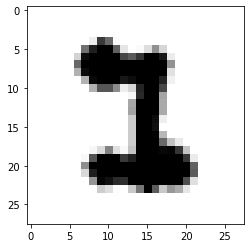



61 [ Predicted Value: 4, Actual Value: 9 ]


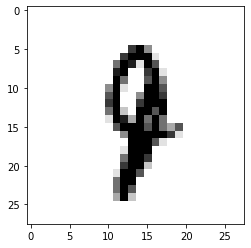



62 [ Predicted Value: 6, Actual Value: 5 ]


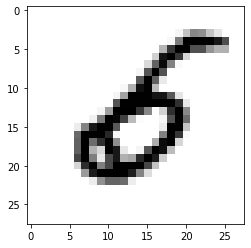



63 [ Predicted Value: 0, Actual Value: 6 ]


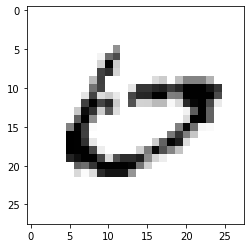



64 [ Predicted Value: 2, Actual Value: 8 ]


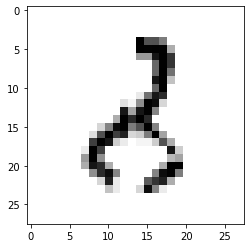



65 [ Predicted Value: 2, Actual Value: 3 ]


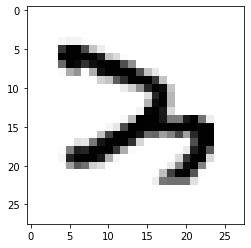



66 [ Predicted Value: 0, Actual Value: 6 ]


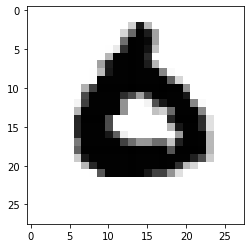

In [93]:
#Let's visualize the images
%matplotlib inline
import matplotlib.pyplot as plt

def miscImages(model, device, test_loader):
    model.eval()
    test_loss = 0
    incorrect = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

            for i in range(len(target)):
              if pred[i].item() != target[i]:
                incorrect += 1
                print('\n\n{} [ Predicted Value: {}, Actual Value: {} ]'.format(
                incorrect, pred[i].item(), target[i], ))
                plt.imshow(data[i].cpu().numpy().squeeze(), cmap='gray_r')
                plt.show()

miscImages(model, device, test_loader)

